
___
# **Parameter Estimation for Reverse Osmosis System**
___

Author: Chenyu Wang

In this tutorial, we will be going through how to set up a parameter estimation using the Pyomo tool ***parmest*** for a reverse osmosis (RO) system. This simple case study aims to validate the RO model by the real plant data.

___
## **Part 1 - Solve Parameter Estimation with Real Plant Data**
### **1.1 Import required modules**
Import all Pyomo, WaterTAP and helper modules needed for building and solving the parameter estimation problem.

In [1]:
# Imports from Pyomo
from pyomo.environ import (
    ConcreteModel,
    TerminationCondition,
    value,
    units,
    Reals,
    TransformationFactory,
    assert_optimal_termination,
)
from pyomo.network import Arc
import pyomo.contrib.parmest.parmest as parmest  # to perform the parameter estimation

# Imports from IDAES
from idaes.core import FlowsheetBlock
from idaes.models.unit_models import Feed, Separator
from idaes.core.util.initialization import propagate_state
from idaes.core.util.model_statistics import degrees_of_freedom
import idaes.core.util.scaling as iscale
import idaes.logger as idaeslog

# Imports from WaterTAP
from watertap.unit_models.reverse_osmosis_0D import (
    ReverseOsmosis0D as RO,
    ConcentrationPolarizationType,
    MassTransferCoefficient,
)
from watertap.property_models import seawater_prop_pack as props
from watertap.core.solvers import get_solver  # to bring in ipopt solver

# Other imports
import pandas as pd  # to create a pandas dataframe to organize the data
import numpy as np  # to manipulate the data into a usable format
import matplotlib.pyplot as plt  # to plot the results
from utility_functions import load_data
import logging
import warnings

logging.getLogger("pyomo").setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore")

### **1.2 Gather and prepare the data**
*How does data need to be formatted for parmest?*


- **Pandas Dataframe:** each column is an observed quantity (temperature, concentration, vapor pressure, etc.), each row is a distinct scenario (25, 0.02, 31.33)

**Other options:**
- **List of dictionaries:** each entry of the list is a distinct scenario, each key an observed quantity 
- **List of json file names:** each entry of the list contains a json file with the distinct scenario (for large datasets in parallel computing)

In this tutorial, we use the data collected from a pilot plan of **Orange County Water District (OCWD)** for a RO unit.

In [2]:
# Read in xlsx file to pd.dataframe
raw_data = pd.read_csv("Plant_data.csv")
# Prepare the data
data, full_data = load_data(raw_data)
display(data)

,flow_vol_in,mass_frac_TDS_in,pressure_in,deltaP,flow_vol_permeate,mass_frac_TDS_permeate
31,6.011,0.001276,179.121,11.701,4.687,0.000024
32,6.035,0.001275,179.166,11.611,4.716,0.000025
33,6.049,0.001275,179.030,11.565,4.732,0.000025
34,6.037,0.001276,178.895,11.656,4.718,0.000024
35,6.024,0.001271,178.804,11.655,4.710,0.000025
36,6.050,0.001275,178.985,11.565,4.724,0.000025
37,6.060,0.001272,178.985,11.656,4.740,0.000025
38,6.034,0.001276,179.121,11.746,4.708,0.000024
39,6.035,0.001278,179.075,11.565,4.704,0.000025
40,6.026,0.001280,179.211,11.610,4.712,0.000025


### **1.3 Define the RO model for parameter estimation**
*What model are parameters being fit to?*

***Parmest*** requires a "model function" to be defined that takes in the data and returns a Pyomo model.

Set up the Pyomo model defining:
- Pyomo Vars or Params for each parameter (or 'theta') to be estimated
- the model equation (a function of the observed data, i.e., permeate flow rate, mass fraction)

 

For this example, the RO model we are proposing is defined as `ro_parmest` function:


In [3]:
# Set the solver
solver = get_solver()  # this will make the ipopt solver available

# Define global conversion factors
psi_to_pascal = 6894.75  # Pressure conversion
gpm_to_m3ps = 6.309e-005  # Vol. flow conversion

In [4]:
def ro_parmest(data):
    # Build the flowsheet
    m = ConcreteModel()
    m.fs = FlowsheetBlock(dynamic=False)
    m.fs.properties = props.SeawaterParameterBlock()
    m.fs.feed = Feed(property_package=m.fs.properties)
    m.fs.RO = RO(
        property_package=m.fs.properties,
        has_pressure_change=True,
        concentration_polarization_type=ConcentrationPolarizationType.none,
        mass_transfer_coefficient=MassTransferCoefficient.none,
    )

    m.fs.s00 = Arc(source=m.fs.feed.outlet, destination=m.fs.RO.inlet)
    TransformationFactory("network.expand_arcs").apply_to(m)

    # Set operating conditions
    m.fs.feed.properties[0].flow_vol_phase.fix(gpm_to_m3ps * 8)
    m.fs.feed.properties[0].temperature.fix(273.15 + 25)
    m.fs.feed.properties[0].pressure.fix(psi_to_pascal * 188)
    m.fs.feed.properties[0].mass_frac_phase_comp["Liq", "TDS"].fix(0.001)

    m.fs.RO.area.fix(28.8)  # Data is for 4 membrane elements
    m.fs.RO.permeate.pressure[0].fix(101325)
    m.fs.RO.deltaP.fix(-psi_to_pascal * 24.6)

    # Initialize A and B values (parameters)
    m.fs.RO.A_comp[0, "H2O"].fix(5e-12)
    m.fs.RO.B_comp[0, "TDS"].fix(4e-8)

    # Set scaling factors
    m.fs.properties.set_default_scaling(
        "flow_mass_phase_comp", 1e1, index=("Liq", "H2O")
    )
    m.fs.properties.set_default_scaling(
        "flow_mass_phase_comp", 1e6, index=("Liq", "TDS")
    )
    iscale.set_scaling_factor(m.fs.RO.area, 1e-1)
    iscale.calculate_scaling_factors(m)

    # Initialize the system
    solver.solve(m.fs.feed)
    propagate_state(m.fs.s00)
    m.fs.RO.initialize(outlvl=idaeslog.ERROR)

    # Set actual operating conditions based on the data
    m.fs.feed.properties[0].flow_vol_phase.fix(
        gpm_to_m3ps * float(data.iloc[0]["flow_vol_in"])
    )
    m.fs.feed.properties[0].pressure.fix(
        psi_to_pascal * float(data.iloc[0]["pressure_in"])
    )
    m.fs.feed.properties[0].mass_frac_phase_comp["Liq", "TDS"].fix(
        float(data.iloc[0]["mass_frac_TDS_in"])
    )
    m.fs.RO.deltaP.fix(-psi_to_pascal * float(data.iloc[0]["deltaP"]))

    assert degrees_of_freedom(m) == 0

    return m

### **1.4 Define a list of parameter names**

The variables to be estimated by parmest must be given as a list of strings of the variable names as they are defined in the `ro_parmest`. 

In [5]:
# variables from model to be estimated
# required format: list with strings of param/var names
theta_names = ["fs.RO.A_comp[0, 'H2O']", "fs.RO.B_comp[0, 'TDS']"]

### **1.5 Define an objective function**

Now, we should define an objective function for the parameter estimation. This is the deviation between the observation and the prediction typically chosen to be the sum of squared errors.

$$
\sum_{i=0}^n (observation_i - prediction_i)^2 
$$


In [6]:
def SSE(m, data):
    flow_vol_permeate_std = np.std(gpm_to_m3ps * full_data["flow_vol_permeate"])
    mass_frac_TDS_permeate_std = np.std(full_data["mass_frac_TDS_permeate"])
    expr = 10 * (1 / flow_vol_permeate_std) * (
        (
            gpm_to_m3ps * float(data.iloc[0]["flow_vol_permeate"])
            - m.fs.RO.mixed_permeate[0.0].flow_vol_phase["Liq"]
        )
        ** 2
    ) + 1000 * (1 / mass_frac_TDS_permeate_std) * (
        (
            float(data.iloc[0]["mass_frac_TDS_permeate"])
            - m.fs.RO.mixed_permeate[0.0].mass_frac_phase_comp["Liq", "TDS"]
        )
        ** 2
    )
    return expr

### **1.6 Solve the parameter estimation problem**

Now, we have everything we need for parmest to solve the parameter estimation problem: 

    - ro_parmest
    - data
    - theta_names
    - objective_function


#### **Step 1**: Set up the problem

Set up the parameter estimation problem by creating an instance of the parmest 'Estimator' object and feed it the required inputs.

In [7]:
# create an instance of the parmest estimator
pest = parmest.Estimator(ro_parmest, data, theta_names, SSE, tee=False)

#### **Step 2**: Solve the parameter estimation problem 

Solve the parameter estimation problem by calling theta_est. This will use the entire data set to perform the parameter estimation. 

There are additional options for solving and testing. Further details can be found in the [parmest documentation](https://pyomo.readthedocs.io/en/6.7.0/contributed_packages/parmest/index.html).

In [8]:
# solve the parameter estimation problem
obj, theta = pest.theta_est()

# display results
print("theta:\n", theta)

theta:
 fs.RO.A_comp[0.0,H2O]    1.217534e-11
fs.RO.B_comp[0.0,TDS]    7.272648e-08
dtype: float64


### **1.7 Visualize results**

Finally, we can visualize the results using ***matplotlib*** to create a plot of the data and the parameter estimatation fit. 

#### **Step 1**: Define the model with the optimal parameters

In [9]:
def ro_opt(theta):
    # Build the flowsheet
    m = ConcreteModel()
    m.fs = FlowsheetBlock(dynamic=False)
    m.fs.properties = props.SeawaterParameterBlock()
    m.fs.feed = Feed(property_package=m.fs.properties)
    m.fs.RO = RO(
        property_package=m.fs.properties,
        has_pressure_change=True,
        concentration_polarization_type=ConcentrationPolarizationType.none,
        mass_transfer_coefficient=MassTransferCoefficient.none,
    )

    m.fs.s00 = Arc(source=m.fs.feed.outlet, destination=m.fs.RO.inlet)
    TransformationFactory("network.expand_arcs").apply_to(m)

    # Set initial conditions
    m.fs.feed.properties[0].flow_vol_phase.fix(gpm_to_m3ps * 8)
    m.fs.feed.properties[0].temperature.fix(273.15 + 25)
    m.fs.feed.properties[0].pressure.fix(psi_to_pascal * 188)
    m.fs.feed.properties[0].mass_frac_phase_comp["Liq", "TDS"].fix(0.001)

    m.fs.RO.area.fix(28.8)  # Data is for 4 membrane elements
    m.fs.RO.permeate.pressure[0].fix(101325)
    m.fs.RO.deltaP.fix(-psi_to_pascal * 24.6)

    # Set optimal values of parameters from parmest
    m.fs.RO.A_comp[0, "H2O"].fix(theta.iloc[0])
    m.fs.RO.B_comp[0, "TDS"].fix(theta.iloc[1])

    # Set scaling factors
    m.fs.properties.set_default_scaling(
        "flow_mass_phase_comp", 1e1, index=("Liq", "H2O")
    )
    m.fs.properties.set_default_scaling(
        "flow_mass_phase_comp", 1e6, index=("Liq", "TDS")
    )
    iscale.set_scaling_factor(m.fs.RO.area, 1e-1)
    iscale.calculate_scaling_factors(m)

    # Initialize the system
    solver.solve(m.fs.feed)
    propagate_state(m.fs.s00)
    m.fs.RO.initialize(outlvl=idaeslog.ERROR)

    assert degrees_of_freedom(m) == 0

    return m

#### **Step 2**: Create a table to save model results

In [10]:
# Define a function to save model results
def save_model_results(model_results):
    for i in range(model_results.shape[0]):
        # Update operating conditions
        m.fs.feed.properties[0].flow_vol_phase.fix(
            gpm_to_m3ps * float(model_results.iloc[i]["flow_vol_in"])
        )
        m.fs.feed.properties[0].pressure.fix(
            psi_to_pascal * float(model_results.iloc[i]["pressure_in"])
        )
        m.fs.feed.properties[0].mass_frac_phase_comp["Liq", "TDS"].fix(
            float(model_results.iloc[i]["mass_frac_TDS_in"])
        )
        m.fs.RO.deltaP.fix(-psi_to_pascal * float(model_results.iloc[i]["deltaP"]))

        results = solver.solve(m, tee=False)
        assert_optimal_termination(results)

        model_results.iloc[i]["flow_vol_permeate"] = (
            value(m.fs.RO.mixed_permeate[0.0].flow_vol_phase["Liq"]) / gpm_to_m3ps
        )
        model_results.iloc[i]["mass_frac_TDS_permeate"] = value(
            m.fs.RO.mixed_permeate[0.0].mass_frac_phase_comp["Liq", "TDS"]
        )

In [11]:
# Initialize the model with optimal parameters
m = ro_opt(theta)
# Create a new table to save model results
model_results = full_data.copy()
save_model_results(model_results)

#### **Step 3**: Visualize model vs data comparison

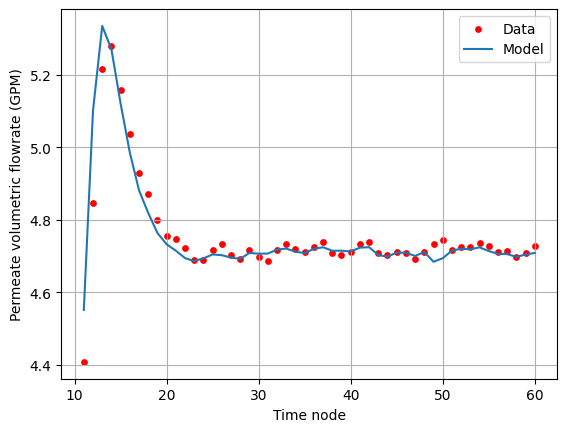

In [12]:
fig, ax = plt.subplots()
ax.scatter(
    full_data.index, full_data["flow_vol_permeate"], label="Data", color="red", s=15
)
ax.plot(model_results.index, model_results["flow_vol_permeate"], label="Model")
ax.set_xlabel("Time node")
ax.set_ylabel("Permeate volumetric flowrate (GPM)")
ax.legend()
ax.grid(True)

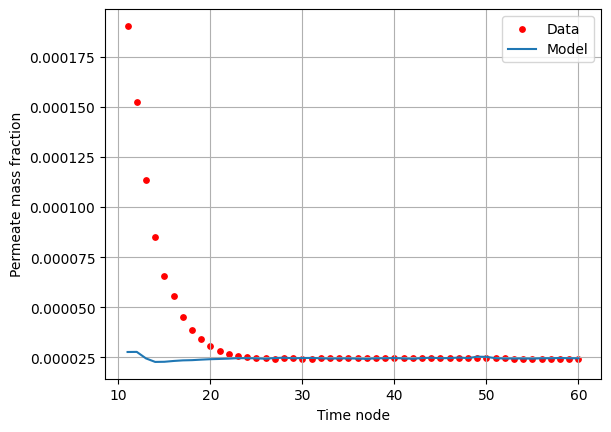

In [13]:
fig2, ax2 = plt.subplots()
ax2.scatter(
    full_data.index,
    full_data["mass_frac_TDS_permeate"],
    label="Data",
    color="red",
    s=15,
)
ax2.plot(model_results.index, model_results["mass_frac_TDS_permeate"], label="Model")
ax2.set_xlabel("Time node")
ax2.set_ylabel("Permeate mass fraction")
ax2.legend()
ax2.grid(True)

## **Part 2 – Try It Yourself: Solve Parameter Estimation with Different Data and Visualize Results**

### **The data set is provided as below named as ``data2``**

In [14]:
data2 = full_data.iloc[30:40]
display(data2)

,flow_vol_in,mass_frac_TDS_in,pressure_in,deltaP,flow_vol_permeate,mass_frac_TDS_permeate
41,6.054,0.001280,179.256,11.655,4.733,0.000025
42,6.067,0.001279,179.075,11.655,4.740,0.000025
43,6.022,0.001281,178.849,11.655,4.707,0.000025
44,6.011,0.001285,178.940,11.656,4.703,0.000025
45,6.039,0.001285,178.985,11.610,4.710,0.000025
46,6.036,0.001285,178.985,11.565,4.709,0.000025
47,6.006,0.001285,179.121,11.656,4.691,0.000024
48,6.038,0.001285,179.030,11.520,4.711,0.000024
49,6.062,0.001351,179.166,11.520,4.733,0.000025
50,6.071,0.001347,179.392,11.565,4.743,0.000024


### **Set up parameter estimation with ``data2``**
In this problem, we use the same model function ``ro_parmest``, parameter names ``theta_names``, and objective function ``SSE``, with a different data set ``data2``. We name the parameter estimation problem as ``pest2``


<details>
  <summary>Click the arrow for Solutions!</summary>

`pest2 = parmest.Estimator(ro_parmest, data2, theta_names, SSE, tee=False)`

</details>

### **Solve the parameter estimation problem and display optimal parameters as ``theta2``**
The objective function is saved as ``obj2`` and optimal parameters are saved as ``theta2``
<details>
  <summary>Click the arrow for Solutions!</summary>

`obj2, theta2 = pest2.theta_est()`

`print("theta2:\n", theta2)`

</details>

theta2:
 fs.RO.A_comp[0.0,H2O]    1.223828e-11
fs.RO.B_comp[0.0,TDS]    7.178219e-08
dtype: float64


### **Create a new table ``model_results2`` to save the results with optimal parameters ``theta2``**
 - First, initialize the model with ``theta2``. 
 - Then, create a new table named ``model_results2`` and save the results in the new table.

<details>
  <summary>Click the arrow for Solutions!</summary>

`m = ro_opt(theta2)`

`model_results2 = full_data.copy()`

`save_model_results(model_results2)`

</details>

### **Visualize the results labeled as ``Model2``**
 - Plot the ``model_results2`` in the same ``ax`` and set the label as ``Model2`` in the same ``ax`` 
 - Update the legend to include the new results
 - Display the figure

<details>
  <summary>Click the arrow for Solutions!</summary>

`ax.plot(model_results2.index, model_results2["flow_vol_permeate"], label="Model2")`

`ax.legend()`

`display(fig)`

</details>

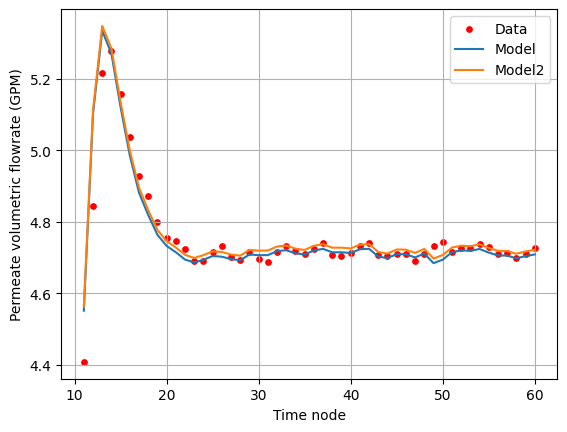